In [81]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 10
    learning_rate = 0.1
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.99

    # Memory
    memory_size = 400

    train = True

class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=2):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3_pi = nn.Linear(256, self.action_size)
        self.fc3_v = nn.Linear(256, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x


class Agent(AgentConfig):
    def __init__(self):
        self.env = gym.make('MountainCar-v0')
        self.env._max_episode_steps = 2000
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train:
            self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        obs, reward, terminal, info = self.env.step(action)
        return obs, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                # print(prob_a)
                if random.random() < 0.001:
                    action = random.choice(range(3))  # Assuming a discrete action space
                else:
                    action = torch.distributions.Categorical(prob_a / 10).sample().item()

                # Act
                state, reward, terminal, _ = self.env.step(action)
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    if episode > 300:
                        solved = True

                    if step % 10 == 0:
                        print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                          'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                    self.scheduler.get_lr()[0]))

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0:
                plot_graph(reward_history, avg_reward)

        self.env.close()
        return reward_history

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']))
        old_probs_a = torch.FloatTensor(self.memory['action_prob'])
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage'])
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage'])
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.FloatTensor(reward) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state)) * torch.FloatTensor(terminal)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state))
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages


def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(np.array(df['x']), np.array(df['Reward']), marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')

    # plt.legend(loc='upper left')
    plt.title("MountainCar", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 10.00, total step: 19990.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: 0.6344, lr: 0.0990


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 20.00, total step: 39980.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: 0.7348, lr: 0.0980


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 30.00, total step: 59970.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: 0.1917, lr: 0.0970


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 40.00, total step: 79960.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.1122, lr: 0.0961


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 50.00, total step: 99950.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: 0.1000, lr: 0.0951


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 60.00, total step: 119940.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: 0.1974, lr: 0.0942


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 70.00, total step: 139930.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.2439, lr: 0.0932


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 80.00, total step: 159920.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.4881, lr: 0.0923


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 90.00, total step: 179910.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.5479, lr: 0.0914


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 100.00, total step: 199900.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.4784, lr: 0.0905


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 110.00, total step: 219890.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.6529, lr: 0.0896


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 117.00, total step: 232860.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.6545, lr: 0.0890


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 127.00, total step: 252850.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.6954, lr: 0.0881


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 137.00, total step: 272840.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7153, lr: 0.0872


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 147.00, total step: 292830.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7036, lr: 0.0863


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 157.00, total step: 312820.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7746, lr: 0.0855


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 182.00, total step: 361940.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7259, lr: 0.0834


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 192.00, total step: 381930.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.8610, lr: 0.0825


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 202.00, total step: 401920.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7873, lr: 0.0817


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 212.00, total step: 421910.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.8692, lr: 0.0809


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 222.00, total step: 441900.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.8287, lr: 0.0801


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 232.00, total step: 461890.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.5733, lr: 0.0793


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 242.00, total step: 481880.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.8609, lr: 0.0785


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 252.00, total step: 501870.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7629, lr: 0.0777


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 262.00, total step: 521860.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.7933, lr: 0.0769


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 272.00, total step: 541850.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.9022, lr: 0.0762


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 282.00, total step: 561840.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.8481, lr: 0.0754


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 291.00, total step: 578820.00, last_episode length: 988.00, last_episode_reward: -987.00, loss: -0.8710, lr: 0.0747
episode: 301.00, total step: 598810.00, last_episode length: 1999.00, last_episode_reward: -1998.00, loss: -0.9540, lr: 0.0740


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


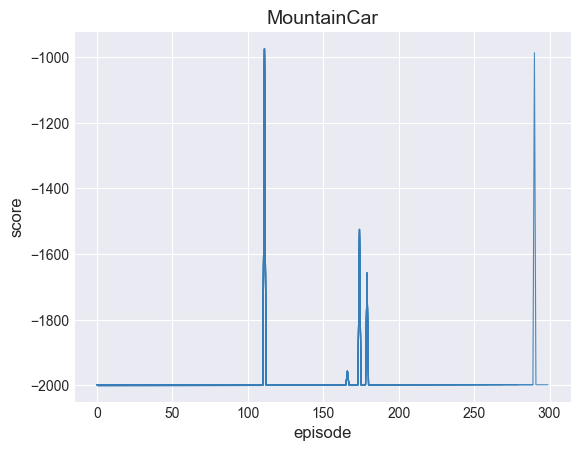

In [82]:
for i in range(1):
    agent = Agent()
    reward_output = agent.train()